In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import time
import json
import os
from threading import Thread
import multiprocessing as mp
import queue as queue #import queue
from networkx.algorithms import community
from matplotlib.pyplot import figure

# my functions implemented in ./src/
from vkprint import vkprint
from crawling_algorythms import Crawler_RC,Crawler_RW,Crawler_DFS,Crawler_BFS,Crawler_MOD,Crawler_MED,Crawler_DE, METRICS_LIST
from utils import import_graph,draw_graph,get_percentile,draw_percentile_heatmap
from utils import draw_nodes_history,draw_scores_history,dump_results

In [2]:
def treading_crawler(seed_num, big_graph, crawling_method,node_seed, b, percentile_set):
    """
    Paralleling algorythm. 1 process for 1 seed. Using global multiprocessing.Queue for export results
    :param seed_num:
    :param big_graph:
    :param crawling_method:
    :param node_seed:
    :param b:
    :param percentile_set:
    :return:
    """
    #global q
    #print('thread alive', seed_num, q.qsize())
    thread_crawler = crawling_method(big_graph, node_seed=node_seed, budget=b, percentile_set=percentile_set)

    counter = 0
    #thread_dump_file = open('../results/dumps/' + graph_name + '/method'+str(methods['RW'])[-5:-2]+seed'+str(node_seed)+str(b)+'.json', 'a+')
    #thread_dump_file.write('[')
    while counter < b:
        if counter % 10000 == 1:
            print(crawling_method,  counter, seed_num)  
            thread_dump_file = open('../results/dumps/'+ graph_name + '/method'+str(crawling_method)[-5:-2]+'seed'+str(node_seed)+'iter_'+str(counter)+'|'+str(b)+'.json', 'w')
            json.dump(thread_crawler.observed_history,thread_dump_file)
            thread_dump_file.close()                   
        counter += 1
        thread_crawler.sampling_process()
                   
        # if counter %100:
        # print(counter)
    # print(seed_num,thread_crawler.observed_history)
    # return_dict[seed_num] = thread_crawler.observed_history
    vkprint('thread ready', seed_num, q.qsize())
    q.put(thread_crawler.observed_history)
    #print(seed_num, 'putted')

In [4]:
%%time
## макропараметры всей задачи
graph_name = 'github'
methods = {'DE':Crawler_DE}#,'RW':Crawler_RW,'RC':Crawler_RC,'DFS':Crawler_DFS, 'BFS':Crawler_BFS, 'MOD':Crawler_MOD,'MED':Crawler_MED} #'AFD',
b = 100
seed_count =1
top_percetile = 10

# общие множества и вспомогательное, лучше не менять

graph_name_list = ['importing','wikivote','hamsterster','DCAM','gnutella',  'dblp2010',  'github']  #'slashdot',
linestyles = [':', '--', '-.','--']*seed_count


# Дальше лучше не трогать
t00 = time.time()
big_graph = import_graph(graph_name)
b = min(big_graph.number_of_nodes(),b)
percentile, percentile_set = get_percentile(big_graph,graph_name,top_percetile) # берём топ 10 процентов вершин
if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
    percentile_set['eccentricity']=set(big_graph.nodes()).difference(percentile_set['eccentricity'])

nx.write_gml(big_graph, "../data/Graphs/"+ graph_name +'_BIG.graph')
vkprint("big_graph "+graph_name+"\nb=",b,"seed count=",seed_count, "methods:",methods, "\n percentile",percentile)


#draw_graph(big_graph,graph_name) # отрисовываем граф, если не очень большой
seeds = random.sample(set(big_graph.nodes),seed_count) # список начальных вершин, по которым мы будем проходиться
crawler = dict()   
crawler_avg = dict()

seeds = random.sample(set(big_graph.nodes),seed_count)
history = dict((method, []*seed_count) for method in methods)
crawler = dict((method, {'nodes':[],'degrees':[],'k_cores':[],'eccentricity':[],
                                  'betweenness_centrality':[]}) for method in methods)
crawler_avg = dict((method, {'nodes':[],#np.zeros([len(methods)*seed_count,b+1]),
                                  'degrees':[],'k_cores':[],'eccentricity':[],'betweenness_centrality':[]}) for method in methods)



# для каждого метода отдельный список тредов, и всё в виде словаря
threads =dict()

for method in methods:   
    #process_queue = list(seeds)    
    #while len(process_queue)>0:
    crawler_avg[method] = dict({i: np.zeros(b) for i in METRICS_LIST}, **{'nodes': np.zeros(b)})
    property_history_hist = {'nodes':[],'degrees':[],'k_cores':[],'eccentricity':[],'betweenness_centrality':[]}
    
    threads [method] = []
    
    for seed_num in range(seed_count):
        #process_method = process_queue.pop()
        t0 =time.time()
        #algorythm = methods[method]
        
    
    q = mp.Queue()
    for seed_num in range(seed_count):
        threads[method].append(mp.Process(daemon = True,target=treading_crawler, args=(seed_num,big_graph,methods[method],seeds[seed_num],b,percentile_set)))
        #threads[method][seed_num].setDaemon = True
        threads[method][seed_num].start()
        
    for seed_num in range(seed_count):
        history[method].append(q.get())
        
    q.close()
    q.join_thread()    
    
    
    for seed_num in range(seed_count):
        threads[method][seed_num].join()
        for prop in METRICS_LIST:
            property_history_hist[prop] = np.array([i for i in history[method][seed_num][prop]])
            crawler_avg[method][prop] += property_history_hist[prop]
        
        crawler_avg[method]['nodes'] += np.array(history[method][seed_num]['nodes'])
        
    #dump_results(graph_name,big_graph,crawler_avg,history)
    vkprint(graph_name, seed_count, method, seed_num,' it took ', round(((time.time() -t0)/60),3),'minutes'  )
dump_results(graph_name,crawler_avg,history,b)
    


 big_graph github
b= 100 seed count= 1 methods: {'DE': <class 'crawling_algorythms.Crawler_DE'>} 
 percentile {'degrees': 13, 'k_cores': 8, 'eccentricity': 7, 'betweenness_centrality': 362582}
<class 'crawling_algorythms.Crawler_DE'> 1 0
 thread ready 0 0


ValueError: operands could not be broadcast together with shapes (100,) (0,) (100,) 

IndexError: list index out of range

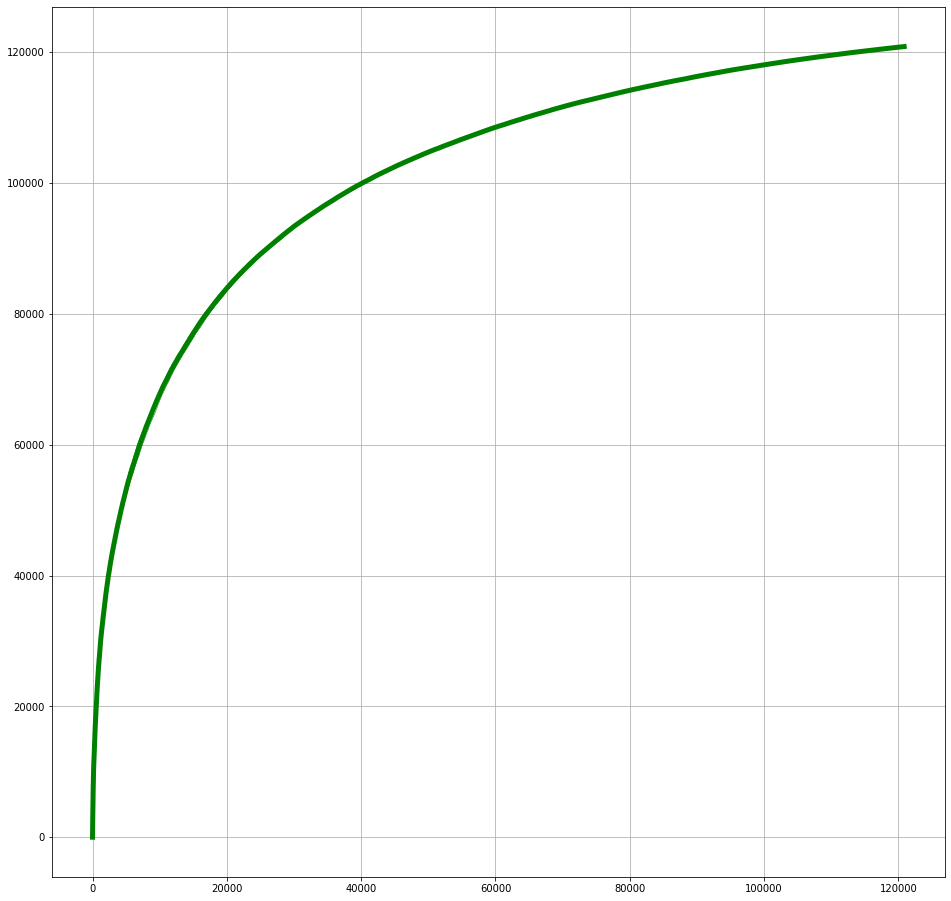

In [9]:
if graph_name == 'gnutella': # большой костыль.Мы брали не тот эксцентриситет
    percentile_set['eccentricity']=set(big_graph.nodes()).difference(percentile_set['eccentricity'])

draw_nodes_history(history,crawler_avg, methods,graph_name,seed_count,b)
percentile, percentile_set = get_percentile(big_graph,graph_name,top_percetile) # берём топ 10 процентов вершин
draw_scores_history(percentile_set,crawler_avg,methods,graph_name,seed_count,b)
draw_percentile_heatmap(percentile_set,graph_name,seed_count,b, normalized=True, venn_on=True)


vkprint('i have done everything!!!!')